Import library and define function

In [27]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)
# viscosity = .01/pi

# Define initial condition
# def fun_u_0(x):
#     return -tf.sin(pi * x)

# Define boundary condition
def fun_u_b(t, x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

# Define residual of the PDE
# parameter
R0 = 0.95
k0 = 2.2
q0 = 1.1
B0 = 0.5
phib = 0.09
c0 = B0/(R0**2*k0*q0)
c1 = B0*(k0**2+1)/(R0**2*k0*q0)
c2 = 0
mu = 1
# R0 = 1
# c1 = 1
# c2 = 1
dp = -c1/mu
F = 1
dF = -c2*R0**2
def fun_r(r, z, phi, phi_r, phi_rr, phi_z, phi_zz):
    return mu*r**2*dp + F*dF+ phi_rr - phi_r/r + phi_zz

Generate collocation points

In [28]:
# Set number of data points
N_0 = 50
N_b = 50
N_r = 1000

# Set boundary
alpha = np.sqrt(2*R0**2*k0*q0*phib/B0)
rmin = np.sqrt(R0**2-2*alpha/k0)
rmax = np.sqrt(R0**2+2*alpha/k0)
# zmin = -1.
# zmax = 1.

# Lower bounds
lb = tf.constant(rmin, dtype=DTYPE)
# Upper bounds
ub = tf.constant(rmax, dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
# r_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
# z_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
# X_0 = tf.concat([r_0, z_0], axis=1)

# Evaluate intitial condition at x_0
# u_0 = fun_u_0(x_0)
r_bound = tf.constant([rmin, rmax], dtype=DTYPE)
z_bound = 1/r_bound*tf.sqrt(alpha**2 - k0**2/4*(r_bound**2-R0**2)**2)
# Boundary data
r_b = tf.random.uniform((N_b,1), lb, ub, dtype=DTYPE)
z_b = 1/r_b*tf.sqrt(alpha**2 - k0**2/4*(r_b**2-R0**2)**2)
X_b_p = tf.concat([r_b, z_b], axis=1)
X_b_n = tf.concat([r_b, -z_b], axis=1)

# Evaluate boundary condition at (t_b,x_b)
phi_b_p = phib*tf.ones((len(z_b),1))
phi_b_n = phib*tf.ones((len(z_b),1))


# Draw uniformly sampled collocation points
r_r = tf.random.uniform((N_r,1), lb, ub, dtype=DTYPE)
z_r = -1/r_r*tf.sqrt(alpha**2 - k0**2/4*(r_r**2-R0**2)**2)
z_r = z_r + tf.random.uniform((len(r_r),1), 0, 1, dtype=DTYPE)*2*(-z_r)
X_r = tf.concat([r_r, z_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_b_p, X_b_n]
phi_data = [phi_b_p, phi_b_n]

In [29]:
alpha**2 - k0**2/4*(r_bound**2-R0**2)**2

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 1.1920929e-07, -5.9604645e-08], dtype=float32)>

Text(0.5, 1.0, 'Positions of collocation points and boundary data')

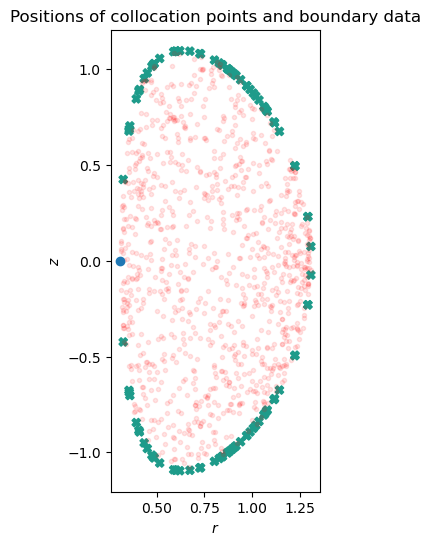

In [30]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
# plt.scatter(t_0, x_0, c=u_0, marker='X', vmin=-1, vmax=1)
plt.scatter(r_b, z_b, c=phi_b_p, marker='X', vmin=-1, vmax=1)
plt.scatter(r_b, -z_b, c=phi_b_n, marker='X', vmin=-1, vmax=1)
plt.scatter(r_r, z_r, c='r', marker='.', alpha=0.1)
plt.scatter(r_bound, z_bound, marker='o')
plt.xlabel('$r$')
plt.ylabel('$z$')
plt.axis('scaled')
plt.title('Positions of collocation points and boundary data')

In [31]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))
    
    return model

In [32]:
def get_r(model, X_r):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        r, z = X_r[:, 0:1], X_r[:,1:2]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(r)
        tape.watch(z)

        # Determine residual 
        phi = model(tf.stack([r[:,0], z[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        phi_r = tape.gradient(phi, r)
        phi_z = tape.gradient(phi, z)
            
    # u_t = tape.gradient(u, t)
    phi_rr = tape.gradient(phi_r, r)
    phi_zz = tape.gradient(phi_z, z)

    del tape

    return fun_r(r, z, phi, phi_r, phi_rr, phi_z, phi_zz)

In [33]:
def compute_loss(model, X_r, X_data, phi_data):
    
    # Compute phi^r
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))
    
    # Initialize loss
    loss = phi_r
    
    # Add phi^0 and phi^b to the loss
    for i in range(len(X_data)):
        phi_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(phi_data[i] - phi_pred))
    
    return loss

In [34]:
def get_grad(model, X_r, X_data, phi_data):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, phi_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [35]:
# Initialize model aka u_\theta
model = init_model()

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.legacy.Adam(learning_rate=lr)

In [36]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_data, phi_data)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    
    return loss

# Number of training epochs
N = 5000
hist = []

# Start timer
t0 = time()

for i in range(N+1):
    
    loss = train_step()
    
    # Append current loss to hist
    hist.append(loss.numpy())
    
    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 2.49944115e+00
It 00050: loss = 1.85366776e-02
It 00100: loss = 3.97217274e-03
It 00150: loss = 3.37457005e-03
It 00200: loss = 8.70449096e-03
It 00250: loss = 5.20597957e-03
It 00300: loss = 1.90630078e-03
It 00350: loss = 4.37690003e-04
It 00400: loss = 4.04628692e-04
It 00450: loss = 2.84385809e-04
It 00500: loss = 1.83626940e-03
It 00550: loss = 4.58651164e-04
It 00600: loss = 7.91405211e-04
It 00650: loss = 3.25111882e-03
It 00700: loss = 2.45978386e-04
It 00750: loss = 2.19493569e-03
It 00800: loss = 1.10674358e-04
It 00850: loss = 3.92183603e-04
It 00900: loss = 1.23903868e-04
It 00950: loss = 1.03040104e-04
It 01000: loss = 1.87674581e-04
It 01050: loss = 8.44596361e-05
It 01100: loss = 7.98928741e-05
It 01150: loss = 7.82861025e-05
It 01200: loss = 7.70619445e-05
It 01250: loss = 7.59435061e-05
It 01300: loss = 7.48623206e-05
It 01350: loss = 7.37979208e-05
It 01400: loss = 7.27433799e-05
It 01450: loss = 7.16946379e-05
It 01500: loss = 7.06497376e-05
It 01550

In [37]:
N = 100
rspace = np.linspace(lb, ub, N, endpoint=False)
zspace = 1/rspace*tf.sqrt(alpha**2 - k0**2/4*(rspace**2-R0**2)**2)
R, Z = np.meshgrid(rspace, zspace)
Xgrid = np.vstack([R.flatten(),Z.flatten()]).T
ineq = Xgrid[:,0]**2*Xgrid[:,1]**2 < alpha**2 - k0**2/4*(Xgrid[:,0]**2-R0**2)**2
Xgrid = Xgrid[ineq]
Xgrid

array([[3.20447257e-01, 2.92296414e-04],
       [3.30413799e-01, 2.92296414e-04],
       [3.40380342e-01, 2.92296414e-04],
       ...,
       [1.26726882e+00, 1.72067438e-01],
       [1.27723536e+00, 1.72067438e-01],
       [1.28720190e+00, 1.72067438e-01]])

Text(0.5, 0.92, 'Solution of GS equation')

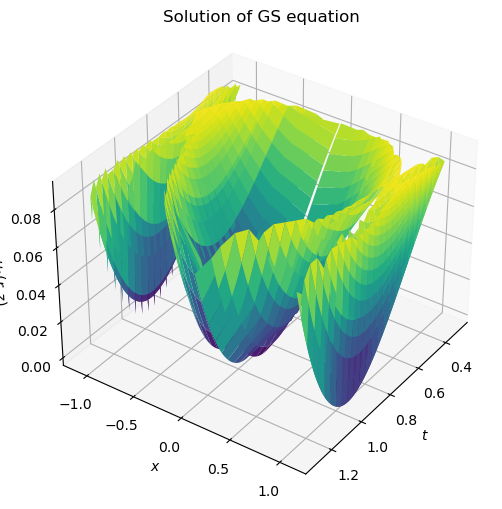

In [38]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 100
rspace = np.linspace(lb, ub, N, endpoint=False)
zspace = 1/rspace*tf.sqrt(alpha**2 - k0**2/4*(rspace**2-R0**2)**2)
R, Z = np.meshgrid(rspace, zspace)
Xgrid = np.vstack([R.flatten(),Z.flatten()]).T
Xgrid = np.concatenate((Xgrid, np.vstack([R.flatten(),-Z.flatten()]).T), axis=0)
ineq = Xgrid[:,0]**2*Xgrid[:,1]**2 <= alpha**2 - k0**2/4*(Xgrid[:,0]**2-R0**2)**2
# Xgrid = Xgrid[ineq]

# Determine predictions of u(t, x)
phipred = model(tf.cast(Xgrid,DTYPE))

# Reshape upred
phi = phipred.numpy().reshape(N,2*N)
ineq = ineq.reshape(N,2*N)
R_ax = Xgrid[:,0].reshape(N,2*N)
Z_ax = Xgrid[:,1].reshape(N,2*N)
phi[~ineq] = np.nan

total_R = np.concatenate((R,R),axis=1)
total_Z = np.concatenate((Z, -Z),axis=1)

# # Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(total_R, total_Z, phi, cmap='viridis')
ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u_\\phi(r,z)$')
ax.set_title('Solution of GS equation')
#plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);

(0.3104807138442993,
 1.2971684432029724,
 -1.0963078017608583,
 1.0963078017608583)

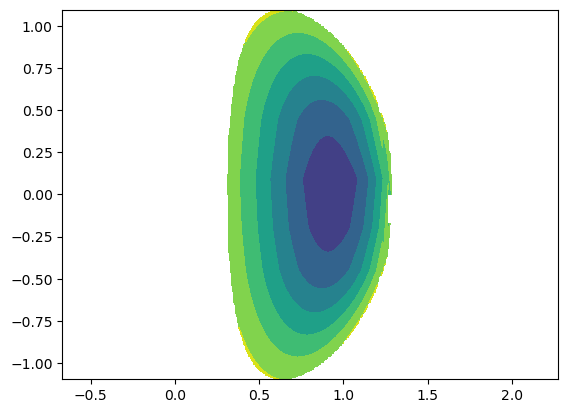

In [39]:
plt.contourf(R_ax, Z_ax, phi)
plt.axis('equal')

(0.26074122786521914,
 1.3550099194049836,
 -1.2059385819369441,
 1.2059385819369441)

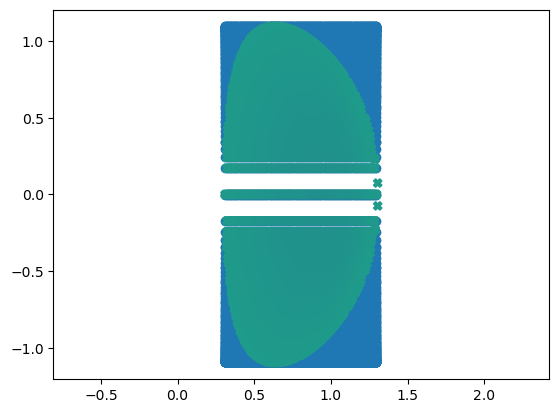

In [40]:
plt.scatter(total_R,total_Z)
plt.scatter(r_b, z_b, c=phi_b_p, marker='X', vmin=-1, vmax=1)
plt.scatter(r_b, -z_b, c=phi_b_n, marker='X', vmin=-1, vmax=1)
plt.scatter(R_ax, Z_ax, c=phi, marker='X', vmin=-1, vmax=1)

plt.axis('equal')

Text(0, 0.5, '$\\phi_{n_{epoch}}$')

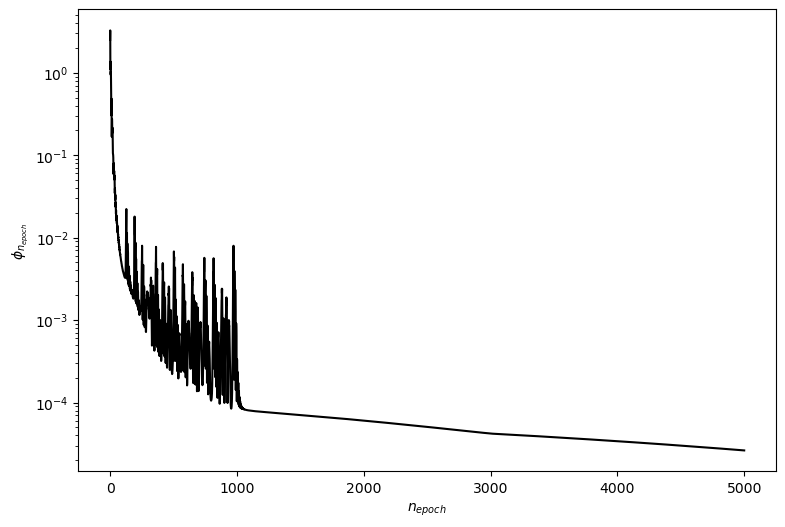

In [41]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$')

In [42]:

phi_analitik = lambda r, z: 0.5*(c2*R0**2 + c0*r**2)*z**2 + 1/8*(c1-c0)*(r**2-R0**2)**2

In [43]:
analitik_sol = phi_analitik(Xgrid[:,0],Xgrid[:,1])
analitik_sol = analitik_sol.reshape(N, 2*N)
analitik_sol[~ineq] = np.nan

(0.3104807138442993,
 1.2971684432029724,
 -1.0963078017608583,
 1.0963078017608583)

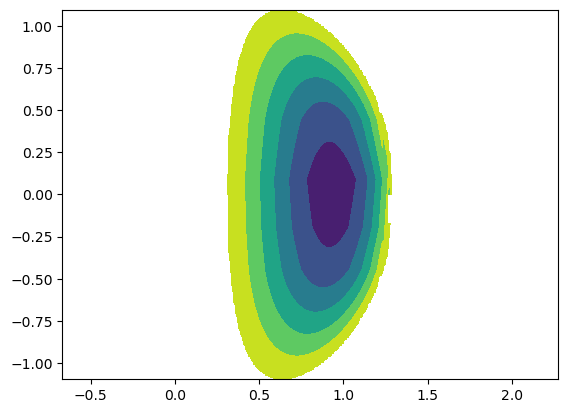

In [44]:
plt.contourf(R_ax, Z_ax, analitik_sol)
plt.axis('equal')

In [45]:
def nabla_phi(model, X_r):
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        r, z = X_r[:, 0:1], X_r[:,1:2]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(r)
        tape.watch(z)

        # Determine residual 
        phi = model(tf.stack([r[:,0], z[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
    phi_r = tape.gradient(phi, r)
    phi_z = tape.gradient(phi, z)

    del tape
    return np.concatenate([phi_r.numpy(), np.zeros((len(X_r),1)), phi_z.numpy()],axis=1)
    

In [46]:
a = np.cross(nabla_phi(model, X_r)/X_r[:,0:1].numpy(),np.array([0,1,0]))